In [141]:
import numpy as np
import pandas as pd
import torch

In [142]:
train_df = pd.read_csv("data/input/train.csv")
test_df = pd.read_csv("data/input/test.csv")
print(train_df.shape , test_df.shape)
print("Train Cols : " , train_df.columns)
print("Test Cols : " , test_df.columns)
print(" Label -  " , [i for i in train_df.columns if i not in test_df.columns] )

(42000, 785) (28000, 784)
Train Cols :  Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Test Cols :  Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
 Label -   ['label']


In [143]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
train_df['label'].value_counts().sort_index()

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64

In [145]:
# Convert df to numpy array
images = np.array(train_df.iloc[:,1:])

# Reshape the array to 32000x784 to 32000x28x28
images = images.reshape(-1,28,28)

In [146]:
images.shape

(42000, 28, 28)

In [147]:
# Scaling the image so that the values only range between 0 and 1
images = images/255.0

# Converting to tensor
images = torch.from_numpy(images)
images = images.to(torch.float32)

In [148]:
# Convert labels to one-hot encoding tensor
labels = np.array(train_df['label'])#.reshape(-1,1)
labels.shape

(42000,)

In [149]:
image_label = np.zeros((images.shape[0], 10))
image_label[np.arange(images.shape[0]), labels] = 1.0

In [150]:
image_label = torch.from_numpy(image_label)
image_label = image_label.to(torch.float32)

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, image_label, test_size=0.1, stratify=train_df['label'])


In [152]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([37800, 28, 28])
torch.Size([37800, 10])
torch.Size([4200, 28, 28])
torch.Size([4200, 10])


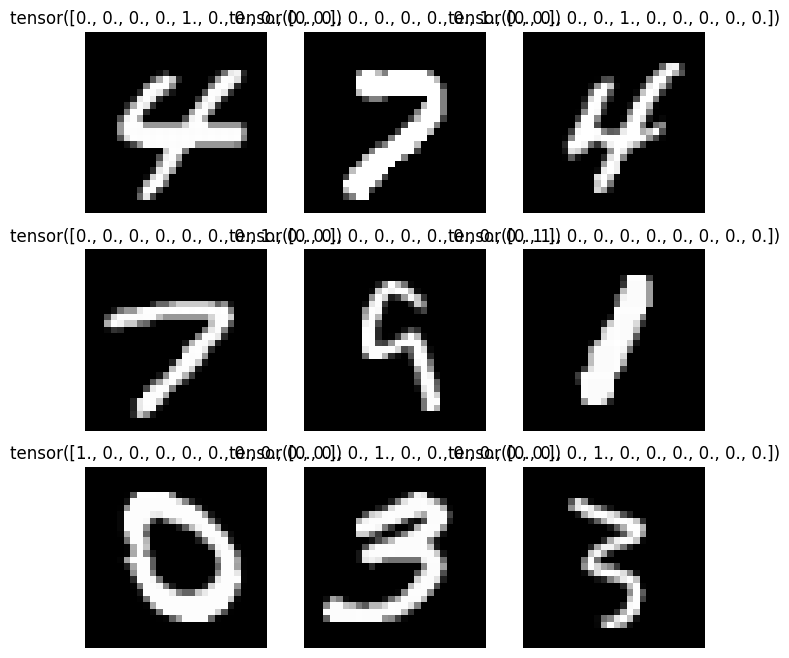

In [153]:
# Ploting some of the datapoints in the dataset
import matplotlib.pyplot as plt

# sample_img , sample_lbl = temp_train_dataset[3]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
plt.axis("off")
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(X_train), size=(1,)).item()
    sample_img = X_train[sample_idx]
    sample_lbl = y_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

In [154]:
## Checking if the GPU is being used properly.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [155]:
from torch import nn

# Softmax layer ignored since the loss function defined is nn.CrossEntropy()
class MyOwnNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyOwnNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return  logits


model = MyOwnNeuralNetwork().to(device)
print(model)

model = model.cuda()
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(0)

MyOwnNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [156]:
## Defining optimizer and loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)

In [157]:
def pytorch_train(dataloader, model, loss_fn, optimizer):
    model.train()

    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))

    for batch, (X, y) in enumerate(dataloader):
        # Feedforward / Loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        _correct = (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/X.shape[0]

        # Updating size and correct
        size += X.shape[0]
        correct += _correct

        if batch % 100 == 0:
            loss = loss.item()
            current = batch * X.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    accuracy = correct / size
    print(f"Train Accuracy: {(100*accuracy):>0.1f}%")

    return batch_loss, batch_accuracy


In [158]:
def pytorch_validation(dataloader, model, loss_fn):
    model.eval()

    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # Feedforward / Loss
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            # Accuracy
            _correct = (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()

            # Updating loss_batch and batch_accuracy
            batch_loss[batch] = loss.item()
            batch_accuracy[batch] = _correct/X.shape[0]

            # Updating size and correct
            size += X.shape[0]
            correct += _correct

    accuracy = correct / size
    print(f"Validation Accuracy: {(100*accuracy):>0.1f}%")

    return batch_loss, batch_accuracy

In [161]:
# Batch the data
batch_size = 64

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


In [162]:
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    _train_batch_loss , _train_batch_accuracy = pytorch_train(train_dataloader, model, loss_fn, optimizer)
    _valid_batch_loss , _valid_batch_accuracy = pytorch_validation(val_dataloader, model, loss_fn)

    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))

    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))
print("Done!")

Epoch 1
-------------------------------
loss: 2.311248  [    0/   64]
loss: 2.181506  [ 6400/ 6464]
loss: 1.714649  [12800/12864]
loss: 0.979786  [19200/19264]
loss: 0.922354  [25600/25664]
loss: 0.789821  [32000/32064]
Train Accuracy: 66.1%
Validation Accuracy: 86.2%
Epoch 2
-------------------------------
loss: 0.664030  [    0/   64]
loss: 0.298472  [ 6400/ 6464]
loss: 0.435603  [12800/12864]
loss: 0.420041  [19200/19264]
loss: 0.333661  [25600/25664]
loss: 0.318780  [32000/32064]
Train Accuracy: 88.8%
Validation Accuracy: 90.2%
Epoch 3
-------------------------------
loss: 0.432677  [    0/   64]
loss: 0.214986  [ 6400/ 6464]
loss: 0.244887  [12800/12864]
loss: 0.168720  [19200/19264]
loss: 0.569802  [25600/25664]
loss: 0.277667  [32000/32064]
Train Accuracy: 90.9%
Validation Accuracy: 91.5%
Epoch 4
-------------------------------
loss: 0.524456  [    0/   64]
loss: 0.199374  [ 6400/ 6464]
loss: 0.438316  [12800/12864]
loss: 0.261311  [19200/19264]
loss: 0.175583  [25600/25664]
los

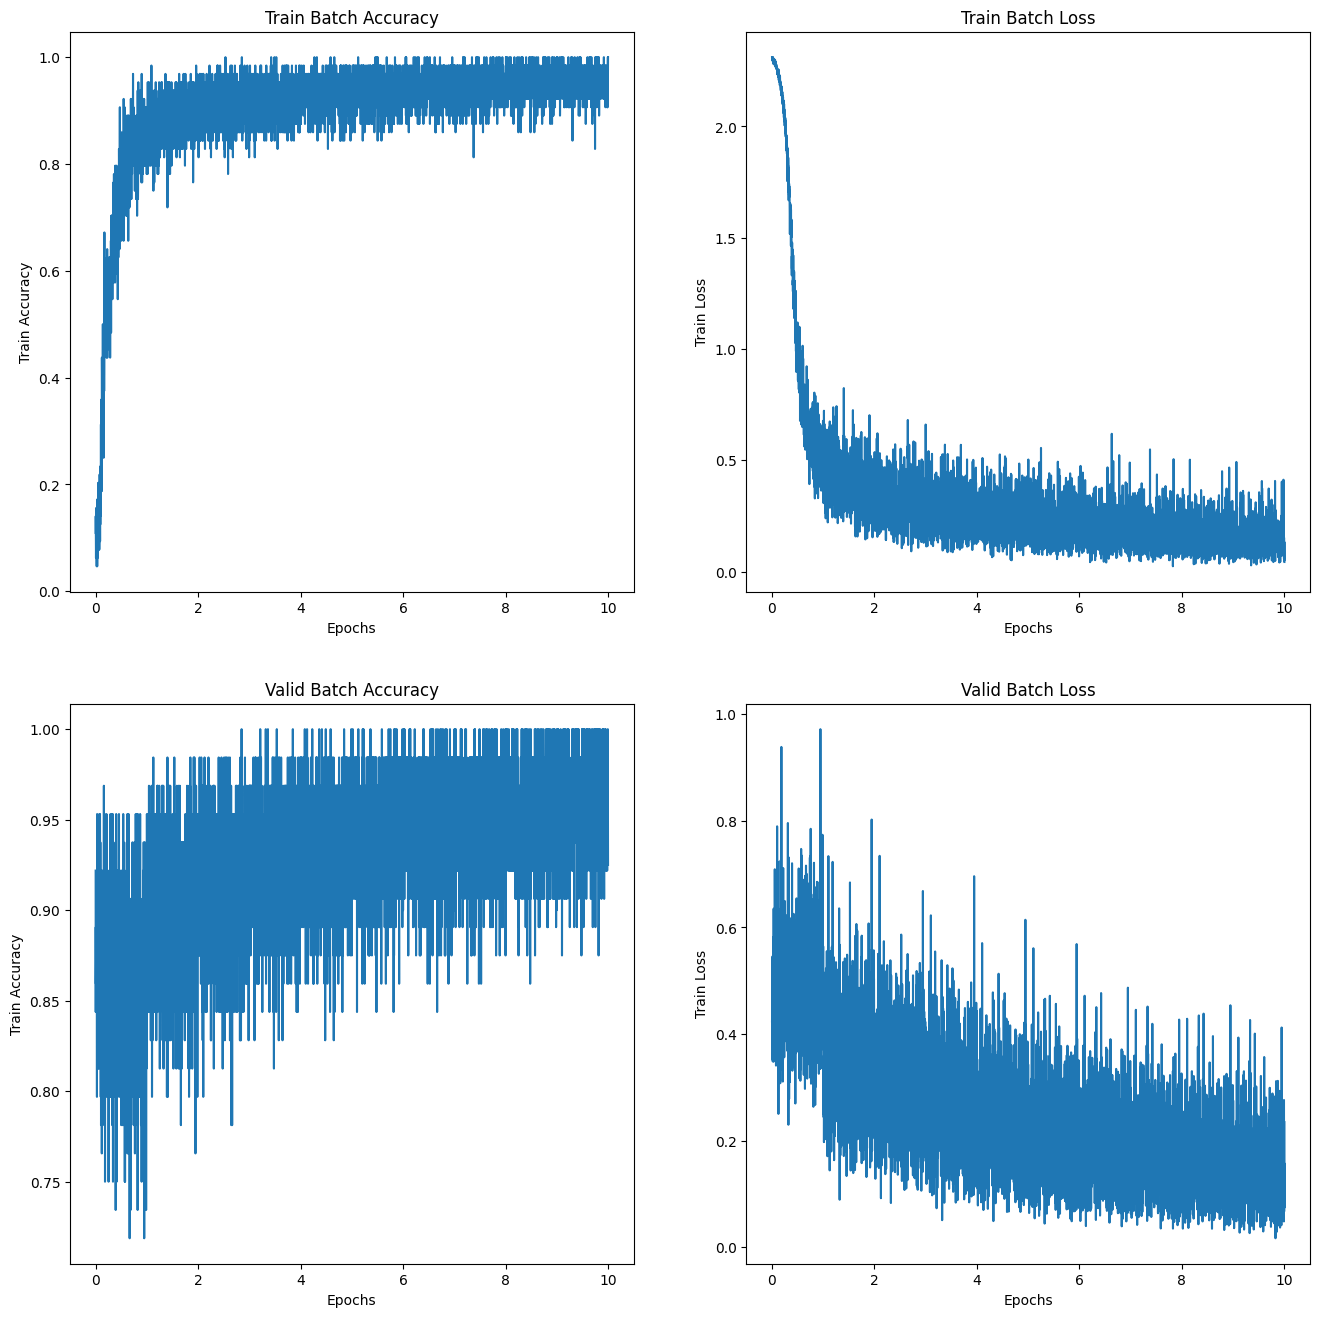

In [163]:
figure = plt.figure(figsize=(16, 16))


figure.add_subplot(2, 2, 1)
plt.plot(train_epoch_no , train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 2)
plt.plot(train_epoch_no , train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

figure.add_subplot(2, 2, 3)
plt.plot(valid_epoch_no , valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 4)
plt.plot(valid_epoch_no , valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")


plt.show()